In [ ]:

import bayesflow as bf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam # type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay # type: ignore

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def simulator_fn(theta, dt=2, max_time=5_000):
    drift, tremor, threshold, drift_rate = theta

    positions = []
    target = np.zeros(2)
    position = np.zeros(2)
    evidence = 0.0
    time = 0.0

    while time < max_time:
        evidence += np.random.normal(loc=drift_rate) * np.sqrt(dt)
        if evidence > threshold:
            evidence = 0.0
            target = np.random.uniform(low=-100, high=100, size=2)
            position = target

        drift_force = drift * (target - position)
        tremor_force = np.random.normal(size=2, scale=tremor)

        velocity = drift_force * dt + tremor_force * np.sqrt(dt)
        position = position + velocity
        positions.append(position)
        time += dt

    positions = np.vstack(positions)
    #positions = positions[0:5000:2]
    return positions

simulator = bf.simulation.Simulator(simulator_fun=simulator_fn)

In [3]:
def prior_fn():
    drift = np.random.gamma(shape=5, scale=0.05) # change from scale=0.01 to scale=0.05
    tremor = np.random.gamma(shape=2, scale=0.5) # change from gamma(5, 0.5) to gamma(2, 0.5) 
    threshold = np.random.gamma(shape=20, scale=2.5)
    drift_rate = np.random.gamma(shape=15, scale=0.01)

    return np.r_[drift, tremor, threshold, drift_rate]

prior = bf.simulation.Prior(prior_fun=prior_fn)

In [4]:
model = bf.simulation.GenerativeModel(simulator=simulator, prior=prior)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2500, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


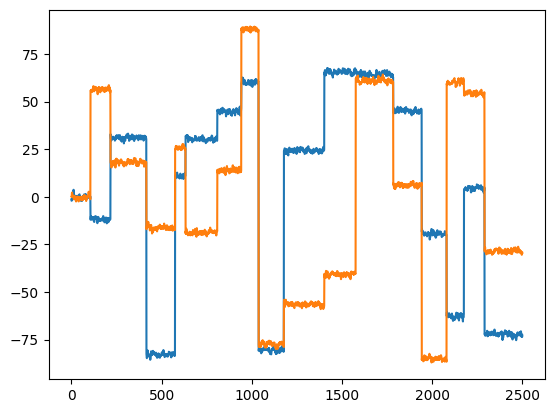

In [5]:
df = model(1)
df = np.array(df['sim_data'])
plt.plot(df[0,:,0])
plt.plot(df[0,:,1])

In [6]:
def configurator(input_dict):
    position = input_dict["sim_data"]
    batch_size, num_timesteps, data_dim = position.shape
    time_encoding = np.linspace(0, 1, num_timesteps)
    time_encoding_batched = np.tile(time_encoding[np.newaxis, :, np.newaxis], (batch_size, 1, 1))
    return {
        "parameters": np.log(input_dict["prior_draws"]).astype(np.float32),
        "summary_conditions": np.concatenate((position, time_encoding_batched), axis=-1).astype(np.float32)
    }

In [8]:
def build_summary_net(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Temporal feature extraction
    x = layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu')(inputs)
    x = layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(x)
    
    # Bidirectional LSTM for temporal statistics
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    
    # Self-attention mechanism
    attention = layers.MultiHeadAttention(num_heads=2, key_dim=32)
    x = attention(x, x)

    # Fully connected layers
    outputs = layers.Bidirectional(layers.LSTM(32))(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
summary_net = build_summary_net((None, 3))

In [ ]:
#summary_net(configurator(model(8))['summary_conditions'])

In [ ]:
inference_net = bf.helper_networks.ConfigurableMLP(input_dim=64, output_dim=4, dropout_rate=0.0)
amortizer = bf.amortizers.AmortizedPointEstimator(inference_net=inference_net, summary_net=summary_net, norm_ord=2)

In [12]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model, configurator=configurator)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [13]:
n_data_sets = 2_000
offline_data = trainer.generative_model(n_data_sets)

In [14]:
epochs = 20
batch_size=64
iterations_per_epoch = int(n_data_sets/batch_size)
schedule = CosineDecay(0.005, epochs * iterations_per_epoch, name = "lr_decay")
optimizer = Adam(schedule, global_clipnorm = 1.0)
h=trainer.train_offline(simulations_dict=offline_data, epochs=epochs, batch_size=batch_size, validation_sims=100, optimizer=optimizer)

INFO:root:Generated 100 simulations for validation.
Training epoch 1: 100%|██████████| 32/32 [01:08<00:00,  2.13s/it, Epoch: 1, Batch: 32,Loss: 0.926,Avg.Loss: 2.098,LR: 4.97E-03]
INFO:root:Validation, Epoch: 1, Loss: 0.819
Training epoch 2: 100%|██████████| 32/32 [01:05<00:00,  2.03s/it, Epoch: 2, Batch: 32,Loss: 0.862,Avg.Loss: 0.956,LR: 4.87E-03]
INFO:root:Validation, Epoch: 2, Loss: 0.857
Training epoch 3: 100%|██████████| 32/32 [01:05<00:00,  2.04s/it, Epoch: 3, Batch: 32,Loss: 1.362,Avg.Loss: 1.038,LR: 4.71E-03]
INFO:root:Validation, Epoch: 3, Loss: 0.946
Training epoch 4: 100%|██████████| 32/32 [01:09<00:00,  2.16s/it, Epoch: 4, Batch: 32,Loss: 0.725,Avg.Loss: 0.895,LR: 4.49E-03]
INFO:root:Validation, Epoch: 4, Loss: 0.530
Training epoch 5: 100%|██████████| 32/32 [01:08<00:00,  2.13s/it, Epoch: 5, Batch: 32,Loss: 0.592,Avg.Loss: 0.605,LR: 4.22E-03]
INFO:root:Validation, Epoch: 5, Loss: 0.545
Training epoch 6: 100%|██████████| 32/32 [01:05<00:00,  2.06s/it, Epoch: 6, Batch: 32,Lo

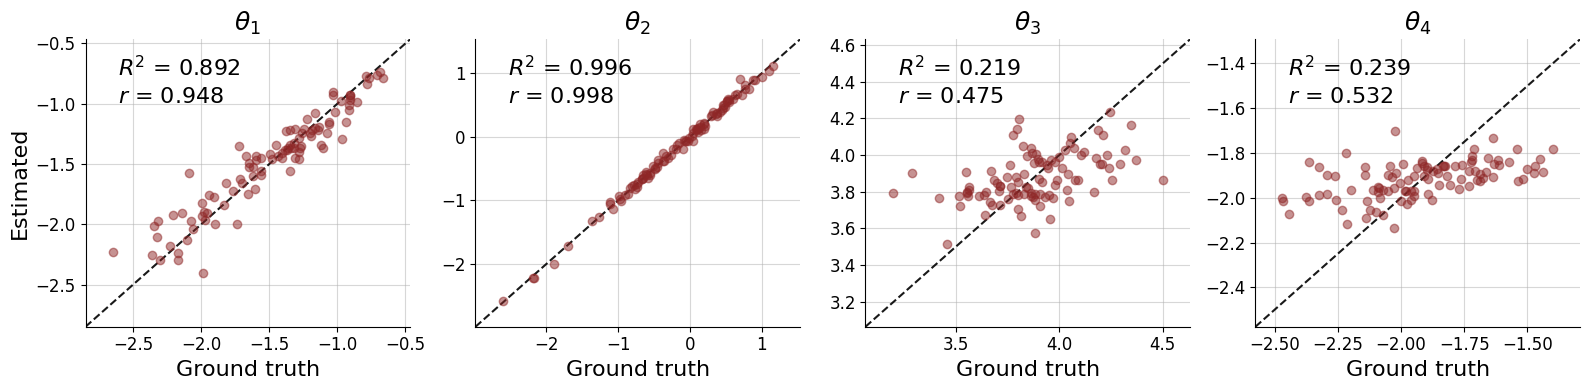

In [15]:
df = configurator(model(100))
estimates = amortizer.estimate(df)
f = bf.diagnostics.plot_recovery(
    estimates[:, None], df['parameters'], uncertainty_agg=lambda x, *args, **kwargs: tf.zeros_like(x)[:, 0]
)